# Section 6.1.4: DeepHit (Competing Events) Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement DeepHit with competing risks (Lee et al., 2018) using PyCox and PyTorch. For an overview of how the DeepHit model works, please see Section 6.1.4 of the monograph. This demo builds off the DeepHit (single event) demo (`S2.3.3_DeepHit_single.ipynb`), so please look at that first. We now consider a setting where there are two competing events. We specifically use the PBC dataset (Fleming and Harrington, 1991), for which the first event is "death" and the second is "transplanted". Note that the PBC dataset is actually a time series dataset but per data point, we only consider the initial time step, so that we reduce it to a tabular dataset. Now that we consider two competing events, we use PyCox's `DeepHit` model (instead of `DeepHitSingle` as in the earlier demo).

### Loading in the PBC dataset (Fleming and Harrington, 1991)

We begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('pbc', competing=True)

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 1088
Validation set size 273
Test set size 584

Features before preprocessing (15 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'histologic', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'age']

Features after preprocessing (17 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'histologic_norm', 'serBilir_std', 'serChol_std', 'albumin_std', 'alkaline_std', 'SGOT_std', 'platelets_std', 'prothrombin_std', 'age_std', 'edema_no', 'edema_yes_despite_diuretics', 'edema_yes_without_diuretics']

Events: ['death', 'transplanted']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Discretizing time

We use PyCox's provided `LabTransDiscreteTime` class that helps with discretizing time.

In [3]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

# ----------------------------------------------------------------------
# as pointed out in PyCox's DeepHit for competing risks demo, we need a
# custom label transformer to support multiple critical events
# https://github.com/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb
class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')
# ----------------------------------------------------------------------

num_time_steps = 16  # set this to 0 to use all unique times in which any critical event happens

if num_time_steps == 0:
    mask = (D_train_np >= 1)  # boolean mask specifying which training points were not censored
    label_transform = LabTransform(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransform(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 16
Time grid: [ 0.          0.2765305   0.86518455  1.5660936   2.1602235   2.883036
  3.5593035   4.205454    5.013142    5.790713    6.6203046   7.90713
  9.114554   10.510897   13.782719   14.152338  ]


### Preparing training and validation sets for use with PyTorch

Note that at this point the observed times have been converted into discrete indices. Note that at the time of writing, the code is a bit picky about the data types used.

In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the DeepHit model and loss

We are now ready to set up the DeepHit model using PyCox's `DeepHit` class. The main difference between this class and the `DeepHitSingle` class in the earlier DeepHit (single event) demo is that the base neural net's output needs to be of the shape (batch size, number of critical events, number of discrete time steps).

In [5]:
import torch.nn as nn
from pycox.models import DeepHit

torch.manual_seed(0)

class BasicMLPForDeepHit(nn.Module):
    def __init__(self, num_input_features, num_critical_events, num_hidden):
        super(BasicMLPForDeepHit, self).__init__()

        self.num_critical_events = num_critical_events
        self.mlp = nn.Sequential(
            nn.Linear(num_input_features, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden,
                      num_critical_events * output_num_time_steps)).to(device)

    def forward(self, inputs):
        mlp_output = self.mlp(inputs)
        return mlp_output.view(inputs.size(0), self.num_critical_events, -1)

num_input_features = X_train.size(1)

base_neural_net = BasicMLPForDeepHit(num_input_features, 2, 8).to(device)

deephit_model = DeepHit(base_neural_net, alpha=0.9, sigma=0.1, device=device,
                        duration_index=time_grid_train_np)
deephit_loss = deephit_model.loss  # we'll see how to use this loss function in the next code cell

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [6]:
from copy import deepcopy
from torch.utils.data import DataLoader
from pycox.models.data import pair_rank_mat

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 0.005

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)

        rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
        rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)

        loss_batch = deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            train_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            val_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 1.8580601215362549 - val loss 1.9956085681915283
Epoch 2 - train loss 1.779083490371704 - val loss 1.9252431392669678
Epoch 3 - train loss 1.6905831098556519 - val loss 1.848314881324768
Epoch 4 - train loss 1.6160452365875244 - val loss 1.7816944122314453
Epoch 5 - train loss 1.5563222169876099 - val loss 1.728129506111145
Epoch 6 - train loss 1.508585810661316 - val loss 1.6877520084381104
Epoch 7 - train loss 1.473837971687317 - val loss 1.6661206483840942
Epoch 8 - train loss 1.4473427534103394 - val loss 1.6554330587387085
Epoch 9 - train loss 1.4248652458190918 - val loss 1.6356233358383179
Epoch 10 - train loss 1.406496286392212 - val loss 1.6300891637802124
Epoch 11 - train loss 1.393070936203003 - val loss 1.6284443140029907
Epoch 12 - train loss 1.3795939683914185 - val loss 1.623216986656189
Epoch 13 - train loss 1.3689498901367188 - val loss 1.6208003759384155
Epoch 14 - train loss 1.3580920696258545 - val loss 1.6169861555099487
Epoch 15 - train loss 1

<All keys matched successfully>

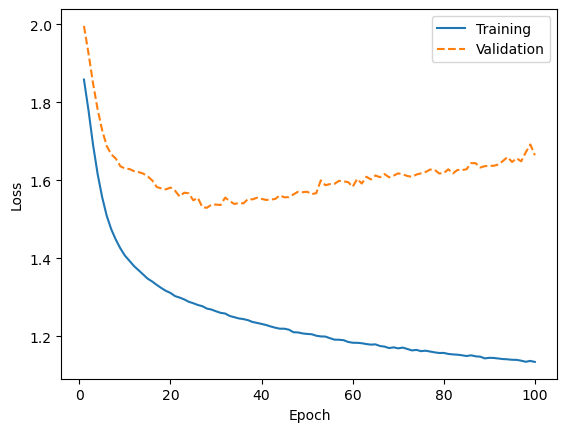

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set cumulative incidence functions (CIFs)

We begin by preprocessing the test data using the preprocessor built using training data.

In [8]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')
X_test_np.shape

(584, 17)

PyCox has built-in functionality for predicting cumulative incidence functions (CIFs):

In [9]:
cif_test_np = deephit_model.predict_cif(X_test_np, batch_size=batch_size, to_cpu=True, numpy=True)
cif_test_np.shape  # shape: (number of critical events, number of time steps in `time_grid_train_np`, number of test points)

(2, 16, 584)

Here, we plot test subject 0's CIFs for the two events:

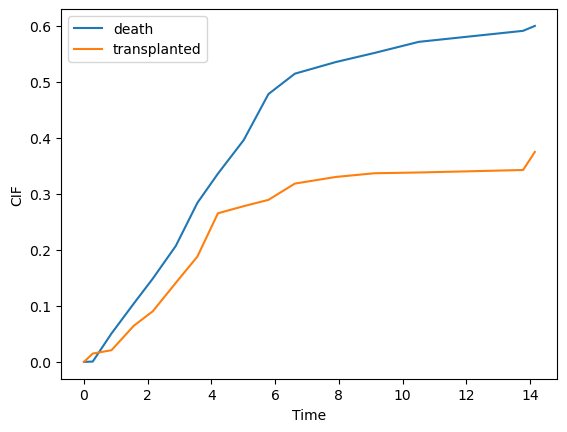

In [10]:
for event_idx, event in enumerate(events):
    plt.plot(time_grid_train_np, cif_test_np[event_idx, :, 0], label=event)
plt.xlabel('Time')
plt.ylabel('CIF')
plt.legend()

### Computing test set evaluation metrics

At the time of writing, survival analysis evaluation metrics that have been implemented in Python typically do not handle the competing risks setup. However, by carefully setting up the inputs to these evaluation metrics, we can evaluate CIFs using the evaluation metrics described in Section 6.1.5 of the monograph.

Some metrics depend on evaluation times, which we pick based on the test set's observed times.

In [11]:
time_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [12]:
import pandas as pd
from pycox.evaluation import EvalSurv

for event_idx_minus_one, event in enumerate(events):
    one_minus_cif_df = pd.DataFrame(1 - cif_test_np[event_idx_minus_one, :, :], index=time_grid_train_np)

    # remember that in `Y_test_np`, the critical events are numbered starting from 1 and not 0
    eval_pycox = EvalSurv(one_minus_cif_df, Y_test_np, 1*(D_test_np == (event_idx_minus_one + 1)))

    C_td = eval_pycox.concordance_td('antolini')
    print(f'Event "{event}" - time-dependent concordance index: {C_td}')

Event "death" - time-dependent concordance index: 0.8273025466191436
Event "transplanted" - time-dependent concordance index: 0.8393383674937073


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

Note that the training data are specifically used to estimate the censoring distribution (for inverse probability of censoring weights -- the $w_i$ weights in equation (6.8) of the monograph), so it suffices to set the training event indicators to be 1 if *any* of the competing critical events happen, and 0 if censoring happens.

In [13]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(1*(D_train_np >= 1), Y_train_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for event_idx_minus_one, event in enumerate(events):
    # convert test labels into the structured array format used by scikit-survival
    labels_test_sksurv = Surv.from_arrays(1*(D_test_np == (event_idx_minus_one + 1)), Y_test_np)

    for eval_time_index in eval_time_indices:
        eval_time = time_grid_test_np[eval_time_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
        cif_values_at_eval_time_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, cif_values_at_eval_time_np, tau=eval_time)[0]
        print(f'Event "{event}" - eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Event "death" - eval time 2.261526584625244 - truncated time-dependent concordance: 0.8872911850728724
Event "death" - eval time 4.591501712799072 - truncated time-dependent concordance: 0.8472873120646975
Event "death" - eval time 7.365020275115967 - truncated time-dependent concordance: 0.799431264382065
Event "transplanted" - eval time 2.261526584625244 - truncated time-dependent concordance: 0.8963368951719595
Event "transplanted" - eval time 4.591501712799072 - truncated time-dependent concordance: 0.8631724433225237
Event "transplanted" - eval time 7.365020275115967 - truncated time-dependent concordance: 0.8526024563183686


#### Brier score (Graf et al., 1999) generalized to competing risks

In [14]:
def compute_brier_competing(cif_values_at_time_horizon, censoring_kmf,
                            Y_test, D_test, event_of_interest, time_horizon):
    n = len(Y_test)
    assert len(D_test) == n

    residuals = np.zeros(n)
    for idx in range(n):
        observed_time = Y_test[idx]
        event_indicator = D_test[idx]
        if observed_time > time_horizon:
            weight = censoring_kmf.predict(time_horizon)
            residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
        else:
            weight = censoring_kmf.predict(observed_time)
            if event_indicator == event_of_interest:
                residuals[idx] = (1 - cif_values_at_time_horizon[idx])**2 / weight
            elif event_indicator != event_of_interest and event_indicator != 0:
                residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
    return residuals.mean()

import lifelines
censoring_kmf = lifelines.KaplanMeierFitter()
censoring_kmf.fit(Y_train_np, 1 * (D_train_np == 0))

for event_idx_minus_one, event in enumerate(events):
    for eval_time_index in eval_time_indices:
        eval_time = time_grid_test_np[eval_time_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
        cif_values_at_eval_time_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        brier = \
            compute_brier_competing(cif_values_at_eval_time_np, censoring_kmf,
                                    Y_test_np, D_test_np, event_idx_minus_one + 1, eval_time)
        print(f'Event "{event}" - eval time {eval_time} - Brier score: {brier}')

Event "death" - eval time 2.261526584625244 - Brier score: 0.09193675186594207
Event "death" - eval time 4.591501712799072 - Brier score: 0.13306850304409157
Event "death" - eval time 7.365020275115967 - Brier score: 0.16196698633091045
Event "transplanted" - eval time 2.261526584625244 - Brier score: 0.021615843493337165
Event "transplanted" - eval time 4.591501712799072 - Brier score: 0.04634493540063809
Event "transplanted" - eval time 7.365020275115967 - Brier score: 0.061358183370050765
